# Embedding AND CountV -- SGDC

## Imports and preprocessing -- CountV

In [1]:
import gc
import numpy as np 
from tqdm import tqdm 
tqdm.pandas()
import pandas as pd 
import matplotlib.pyplot as plt 
train_dset_df = pd.read_csv("2020_10_19_train_dset_df_nostem_nostoprem.csv")
train_dset_df["preprocessed_joined"].fillna("", inplace=True)

## Metricsifier

In [2]:
from sklearn.metrics import f1_score, confusion_matrix, precision_score, recall_score

In [3]:
def summarize(y, yhat):
    print("F1 score:", f1_score(y, yhat))
    print("Precision:", precision_score(y, yhat))
    print("Recall:", recall_score(y, yhat))
    print("Confusion matrix:")
    print(confusion_matrix(y, yhat))
    return (f1_score(y, yhat))

## Embedder

In [4]:
import gensim.downloader as gensim_api 


In [5]:
def embedding_entire_dset(dset_df_rows, embedding_vectors):
    '''
    dset_df_rows: A pandas Series. Each entry is a string of space-separated words without numbers and special characters.
    embedding_vectors: A non-trainable embedding vectors instance from Gensim 
    num_embedding_columns: The number of columns.
    ''' 
    num_embedding_columns=300
    num_embedding_rows = len(dset_df_rows)
    mean_embedding_X = np.zeros((num_embedding_rows, num_embedding_columns))
    sum_embedding_X = np.zeros((num_embedding_rows, num_embedding_columns))
    min_embedding_X = np.zeros((num_embedding_rows, num_embedding_columns))
    max_embedding_X = np.zeros((num_embedding_rows, num_embedding_columns))
    for row_index in tqdm(range(num_embedding_rows)):
        words = [word for word in dset_df_rows[row_index].split() if word in embedding_vectors]
        if(len(words) > 0):
            sentence_embedding_matrix = embedding_vectors[words]
            mean_embedding_X[row_index,:] = np.mean(sentence_embedding_matrix,axis=0)
            sum_embedding_X[row_index,:] = np.sum(sentence_embedding_matrix, axis=0)
            min_embedding_X[row_index,:] = np.min(sentence_embedding_matrix, axis=0)
            max_embedding_X[row_index,:] = np.max(sentence_embedding_matrix, axis=0)
    embedding_X = np.concatenate([mean_embedding_X, sum_embedding_X, min_embedding_X, max_embedding_X], axis=1)
    return embedding_X


In [6]:
word2vec = gensim_api.load("word2vec-google-news-300")
train_embedded_X = embedding_entire_dset(train_dset_df["preprocessed_joined"],word2vec)
word2vec = None 
[gc.collect() for i in range(3)]

100%|██████████| 783673/783673 [01:13<00:00, 10604.53it/s]


[0, 0, 0]

In [7]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer()
vectorizer.fit(train_dset_df["preprocessed_joined"])
train_bow_X = vectorizer.transform(train_dset_df["preprocessed_joined"])
train_dset_y = train_dset_df["target"].to_numpy()
train_dset_df = None 
[gc.collect() for i in range(3)]


[0, 0, 0]

## Custom pipeline

In [8]:
def get_dense_array_format(train_embedded_X_subset, train_sparse_X_subset):
    train_sparse_X_in_dense_array = train_sparse_X_subset.toarray()
    to_return = np.hstack([train_embedded_X_subset, train_sparse_X_in_dense_array])
    return to_return

In [9]:
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler
from sklearn.linear_model import SGDClassifier



In [10]:
def testing_pipeline(embedded_X, bow_X, y, model, to_compare_indices, NEW_DSET_SIZE):
    NUMBER_OF_POINTS_TO_COMPARE = to_compare_indices.size
    curr_marker = 0
    to_compare_y = train_dset_y[to_compare_indices]
    to_compare_yhat = np.zeros((NUMBER_OF_POINTS_TO_COMPARE,))
    i = 0
    while(curr_marker < NUMBER_OF_POINTS_TO_COMPARE):
        print("\tTesting pipeline subepoch:", i)
        i += 1
        curr_end_marker = min(NUMBER_OF_POINTS_TO_COMPARE, curr_marker + NEW_DSET_SIZE)
        curr_indices = to_compare_indices[curr_marker:curr_end_marker]
        processed_X = get_dense_array_format(embedded_X[curr_indices,:], bow_X[curr_indices,:])
        [gc.collect() for _ in range(3)]
        to_compare_yhat[curr_marker:curr_end_marker] = sgdc.predict(processed_X).reshape(-1,)
        curr_marker += NEW_DSET_SIZE
        processed_X = None 
        [gc.collect() for _ in range(3)]
    return summarize(to_compare_y, to_compare_yhat)


In [11]:
NUM_TOTAL_TRAINING_EXAMPLES = train_bow_X.shape[0]
_, _, train_indices, test_indices = train_test_split(np.array(range(NUM_TOTAL_TRAINING_EXAMPLES)).reshape(-1, 1), np.array(range(NUM_TOTAL_TRAINING_EXAMPLES)).reshape(-1,), test_size=0.1)
_ = None 

train_f1_scores = []
test_f1_scores  = []
NEW_DSET_SIZE = 45000
NUM_EPOCHS = 80
CHECK_INTERVAL = 5
rus = RandomUnderSampler(sampling_strategy=0.1)
sgdc = SGDClassifier(alpha=0.001, learning_rate="constant", loss="squared_hinge", eta0 = 0.00001, class_weight={0:1, 1:1.8})

for epoch in range(NUM_EPOCHS):
    print("-----------------------------------------------------------")
    print("Epoch number:", epoch)

    # Training
    i = 0
    for _ in range(len(train_indices) // NEW_DSET_SIZE):
        print("\tTraining subepoch:",i)
        i += 1
        sample_indices = np.random.choice(train_indices, size=NEW_DSET_SIZE, replace=False)
        
        resampled_sample_indices, resampled_y = rus.fit_resample(sample_indices.reshape(-1, 1),train_dset_y[sample_indices] )
        resampled_sample_indices = resampled_sample_indices.reshape(-1,)

        train_resampled_processed_X = get_dense_array_format(train_embedded_X[resampled_sample_indices,:], train_bow_X[resampled_sample_indices,:])

        [gc.collect() for _ in range(3)]
        sgdc.partial_fit(train_resampled_processed_X, resampled_y, classes=(0,1))
        train_resampled_processed_X = None
        [gc.collect() for _ in range(3)]

    # Training set metrics
    if(epoch % CHECK_INTERVAL == 0):
        print("Metrics on training set:")
        [gc.collect() for _ in range(3)]
        train_f1_scores.append(testing_pipeline(train_embedded_X, train_bow_X, train_dset_y, sgdc, train_indices, NEW_DSET_SIZE//2))
        [gc.collect() for _ in range(3)]
        print("Metrics on test set:")
        test_f1_scores.append(testing_pipeline(train_embedded_X, train_bow_X,train_dset_y, sgdc, test_indices, NEW_DSET_SIZE//2))

-----------------------------------------------------------
Epoch number: 0
	Training subepoch: 0
	Training subepoch: 1
	Training subepoch: 2
	Training subepoch: 3
	Training subepoch: 4
	Training subepoch: 5
	Training subepoch: 6
	Training subepoch: 7
	Training subepoch: 8
	Training subepoch: 9
	Training subepoch: 10
	Training subepoch: 11
	Training subepoch: 12
	Training subepoch: 13
	Training subepoch: 14
Metrics on training set:
	Testing pipeline subepoch: 0
	Testing pipeline subepoch: 1
	Testing pipeline subepoch: 2
	Testing pipeline subepoch: 3
	Testing pipeline subepoch: 4
	Testing pipeline subepoch: 5
	Testing pipeline subepoch: 6
	Testing pipeline subepoch: 7
	Testing pipeline subepoch: 8
	Testing pipeline subepoch: 9
	Testing pipeline subepoch: 10
	Testing pipeline subepoch: 11
	Testing pipeline subepoch: 12
	Testing pipeline subepoch: 13
	Testing pipeline subepoch: 14
	Testing pipeline subepoch: 15
	Testing pipeline subepoch: 16
	Testing pipeline subepoch: 17
	Testing pipelin

In [11]:
import matplotlib.pyplot as plt

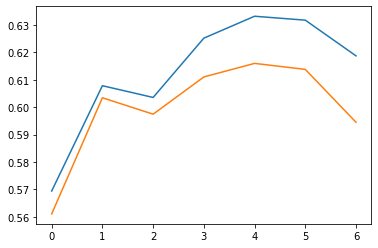

In [12]:
plt.plot(train_f1_scores)
plt.plot(test_f1_scores)
plt.show()